# Figure 5 - Reaction mechanism determination

In [31]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize

import ast

import pymc3 as pm
import arviz as az
import theano.tensor as tt

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-04-08 15:26:25

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

seaborn          : 0.11.1
matplotlib_inline: 0.1.3
arviz            : 0.11.4
matplotlib       : 3.4.2
networkx         : 2.6.3
pandas           : 1.2.4
numpy            : 1.20.3
scipy            : 1.6.2
pymc3            : 3.11.4
theano           : 1.1.2
sys              : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]



## Helper functions for plotting

In [32]:
def savefig(name):
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

XSIZE = 7.0 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def generate_figure(n_col, n_row):
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs


## Data loading

In [42]:
experiments = pd.read_csv(f"../data/kinetic_studies.csv").query(
    f'enzyme == "G6PDH"'
)
data = []
for t in experiments.itertuples():
    df = pd.read_csv(f"../data/{t.data_path}")
    df = df.assign(
        kf=t.flowrate / (60 * t.volume),
        G6PDH=t.enzyme_concentration,
        code=t.experiment_code,
    )
    data.append(df)

data = pd.concat(data).reset_index(drop=True)

data = data.assign(
    NAD_obs=data.NAD_in - data.NADH_obs,
    G6P_obs=data.G6P_in - data.NADH_obs,
    G6PdL_obs=data.NADH_obs
)
# data = data.groupby(['code', 'G6P_in', 'NAD_in']).mean().reset_index()

## Creation of models

In [43]:
exp_idx, exp_coords = data.code.factorize(sort=True)
obs_idx, obs_coords = data.index.factorize(sort=True)
coords = {"exp": exp_coords, 'obs': obs_coords}

with pm.Model(coords=coords) as model_0:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    # KI_NADH = pm.Uniform("KI_NADH", 1, 5000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_1:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_2:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_3:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_4:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_5:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_6:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*KI_NADH*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

## Model sampling

In [44]:
with model_0:
    idata_0 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_1:
    idata_1 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_2:
    idata_2 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_3:
    idata_3 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_4:
    idata_4 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_5:
    idata_5 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_6:
    idata_6 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


# Diagnostics

In [45]:
def sampling_stats(idata: az.InferenceData):
    return pd.DataFrame({'Chains': int(idata.sample_stats.coords['chain'].size), 
    'Tuning steps': int(idata.sample_stats.tuning_steps), 
    'Draws': int(idata.sample_stats.coords['draw'].size),
    'Mean acceptance rate': round(idata.sample_stats.acceptance_rate.mean().values[()], 3),
    'Divergences': int(idata.sample_stats.diverging.sum().values[()]), 
}, index=[0])


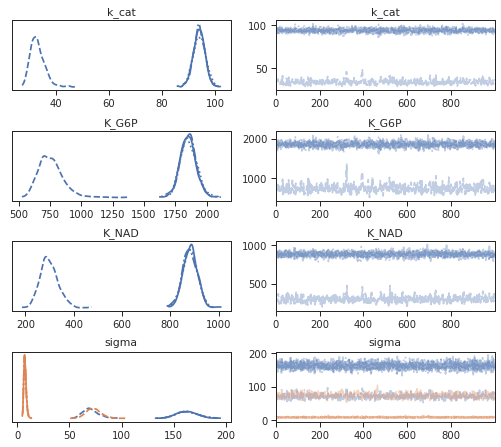

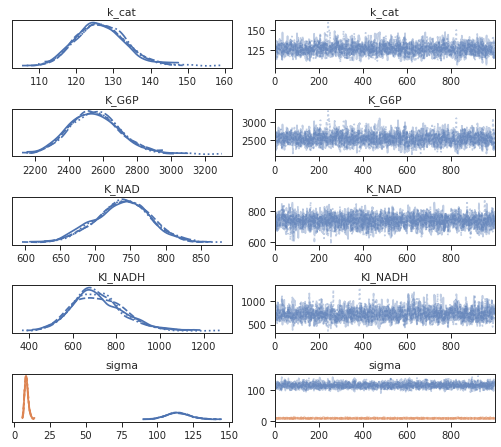

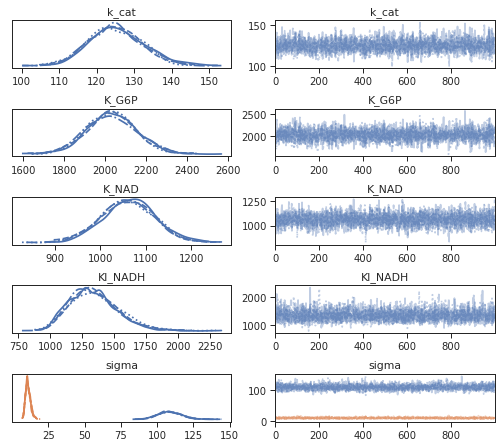

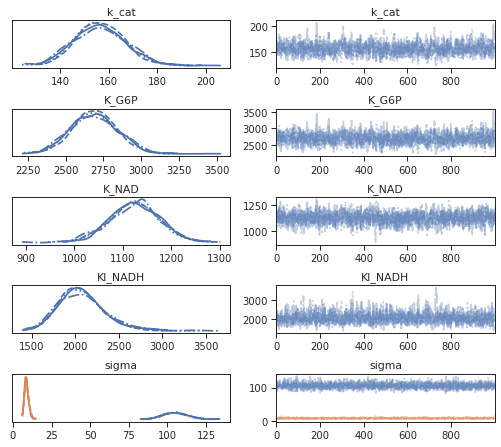

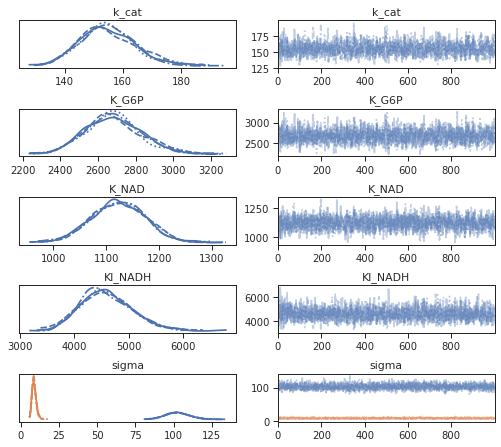

In [46]:
hypothesis = {'H_0': idata_0,
    'H_1': idata_2,
    'H_2': idata_3,
    'H_3': idata_1,
    'H_4': idata_5
}

for k, v in hypothesis.items():
    filename = f"diagnostics/mechanisms_{k}_sampling.md"
    table_str = sampling_stats(v).to_markdown()
    table_str += f'\nTable: Sampling statistics for manuscript Figure 5, Hypothesis {k[-1]}'
    with open(filename, 'wt') as f:
        f.write(table_str)

    filename = f"diagnostics/mechanisms_{k}.md"
    table_str = az.summary(v, kind='diagnostics').round(2).to_markdown()
    table_str += f'\nTable: Sampling diagnostics for manuscript Figure 5, Hypothesis {k[-1]}'
    with open(filename, 'wt') as f:
        f.write(table_str)

    az.plot_trace(v, filter_vars='like', figsize=(7, 1.25*5))
    plt.tight_layout()
    savefig(f"mechanisms_{k}_traces")

## Posterior predictive sampling

In [47]:
with model_0:
    post_pred_0 = pm.sample_posterior_predictive(idata_0, var_names=['NADH_obs'] )
with model_1:
    post_pred_1 = pm.sample_posterior_predictive(idata_1, var_names=['NADH_obs'] )
with model_2:
    post_pred_2 = pm.sample_posterior_predictive(idata_2, var_names=['NADH_obs'] )
with model_3:
    post_pred_3 = pm.sample_posterior_predictive(idata_3, var_names=['NADH_obs'] )
with model_4:
    post_pred_4 = pm.sample_posterior_predictive(idata_4, var_names=['NADH_obs'] )
with model_5:
    post_pred_5 = pm.sample_posterior_predictive(idata_5, var_names=['NADH_obs'] )

## Creation of figure

In [48]:
posterior_0 = idata_0.to_dataframe(['posterior'], include_coords=False)
posterior_1 = idata_1.to_dataframe(['posterior'], include_coords=False)
posterior_2 = idata_2.to_dataframe(['posterior'], include_coords=False)
posterior_3 = idata_3.to_dataframe(['posterior'], include_coords=False)
posterior_4 = idata_4.to_dataframe(['posterior'], include_coords=False)
posterior_5 = idata_5.to_dataframe(['posterior'], include_coords=False)

posteriors = [posterior_0,posterior_2,posterior_3, posterior_1,posterior_5]

In [61]:
data.groupby(['NAD_in', 'G6P_in', 'code']).std()/data.groupby(['NAD_in', 'G6P_in', 'code']).mean()

NADH_obs   kf  G6PDH   NAD_obs   G6P_obs  G6PdL_obs
NAD_in G6P_in code                                                       
1000   500    SNKS08  0.016465  0.0    0.0  0.007706  0.028971   0.016465
              SNKS20  0.013058  0.0    0.0  0.001870  0.004364   0.013058
       1000   SNKS08  0.009667  0.0    0.0  0.010325  0.010325   0.009667
              SNKS20  0.002337  0.0    0.0  0.000617  0.000617   0.002337
       1500   SNKS08  0.016776  0.0    0.0  0.032561  0.013180   0.016776
              SNKS20  0.002718  0.0    0.0  0.001008  0.000598   0.002718
       3000   SNKS08  0.007459  0.0    0.0  0.037893  0.002879   0.007459
              SNKS20  0.003257  0.0    0.0  0.001930  0.000461   0.003257
3000   500    SNKS08  0.022118  0.0    0.0  0.003289  0.076936   0.022118
              SNKS20  0.005108  0.0    0.0  0.000297  0.002507   0.005108
       1000   SNKS08  0.025023  0.0    0.0  0.007939  0.065172   0.025023
              SNKS20  0.003311  0.0    0.0  0.000385  0.001506   0.003311
       1500   SNKS08  0.008067  0.0    0.0  0.003923  0.015270   0.008067
              SNKS20  0.001048  0.0    0.0  0.000173  0.000414   0.001048
       3000   SNKS08  0.009330  0.0    0.0  0.007848  0.007848   0.009330
              SNKS20  0.001193  0.0    0.0  0.000307  0.000307   0.001193

'KI_NADH'


/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


       rank         loo      p_loo      d_loo        weight         se  \
$H_4$     0 -263.995715  11.307434   0.000000  7.676505e-01  32.018767   
$H_3$     1 -266.290637  11.856399   2.294922  1.577626e-01  16.406756   
$H_1$     2 -270.065544  12.440034   6.069829  6.562919e-02  16.454127   
$H_2$     3 -274.879251  13.111388  10.883537  8.957667e-03  17.568376   
$H_0$     4 -335.042095  92.392981  71.046380  2.934743e-09  15.898010   

             dse  warning loo_scale  
$H_4$   0.000000    False       log  
$H_3$   1.890870     True       log  
$H_1$   4.005562    False       log  
$H_2$   4.873163    False       log  
$H_0$  26.650688     True       log  


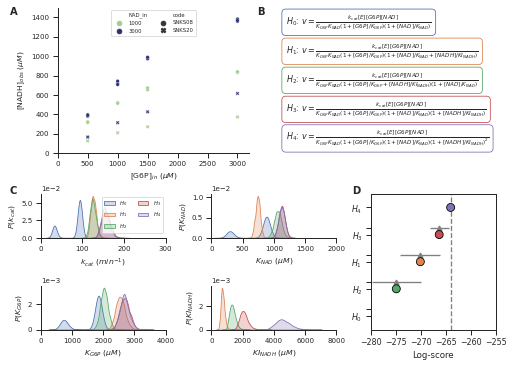

In [65]:
fig = plt.figure(figsize=(XSIZE, YSIZE), constrained_layout=True)
gs0 = fig.add_gridspec(2, 1)

gs = gs0[0].subgridspec(1,2)

ax_1 = fig.add_subplot(gs[0])

sns.scatterplot(ax=ax_1, data=data, x='G6P_in', y='NADH_obs', hue="NAD_in", palette='crest', style='code', markers=True, s=12)
ax_1.set_xlim(0, 3200)
ax_1.set_ylim(0, 1500)
ax_1.set_xlabel(r"$[$G6P$]_{in}~(\mu M)$")
ax_1.set_ylabel(r"$[$NADH$]_{obs}~(\mu M)$")
ax_1.legend(loc='upper center', fontsize='x-small', ncol=2)

ax_3 = fig.add_subplot(gs[1])
ax_3.axis('off')

ax_3.text(x=-0.15, y=0.9, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C0', pad=0.5), 
            s=r"$H_0$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.7, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C1', pad=0.5), 
            s=r"$H_1$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD}+[NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.5, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C2', pad=0.5), 
            s=r"$H_2$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P}+[NADH]/KI_{NADH})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.3, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C3', pad=0.5), 
            s=r"$H_3$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.1, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C4', pad=0.5), 
            s=r"$H_4$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})^2}$")

ax_1.text(-0.25, 0.95, 'A', transform=ax_1.transAxes, weight="bold", size=10)
ax_3.text(-0.3, 0.95, 'B', transform=ax_3.transAxes, weight="bold", size=10)


gs = gs0[1].subgridspec(2,3)
ax_4 = fig.add_subplot(gs[0,0])
ax_5 = fig.add_subplot(gs[1,0])
ax_6 = fig.add_subplot(gs[0,1])
ax_7 = fig.add_subplot(gs[1,1])

ax_4.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_5.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_6.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_7.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
for i, post in enumerate(posteriors):
    sns.kdeplot(post['k_cat'], ax=ax_4, fill=True, color=f'C{i}', label=r"$H_{}$".format(i))
ax_4.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_4.set_ylabel(r"$P(k_{cat})$")
ax_4.set_xlim(0, 300)
ax_4.legend(loc='upper right', ncol=2, markerscale=0.5, fontsize='x-small', title_fontsize='small')

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_G6P'], ax=ax_5, fill=True, color=f'C{i}')
ax_5.set_xlabel(r"$K_{G6P}~(\mu M)$")
ax_5.set_ylabel(r"$P(K_{G6P})$")
ax_5.set_xlim(0, 4000)

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_NAD'], ax=ax_6, fill=True, color=f'C{i}')
ax_6.set_xlabel(r"$K_{NAD}~(\mu M)$")
ax_6.set_ylabel(r"$P(K_{NAD})$")
ax_6.set_xlim(0, 2000)

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['KI_NADH'], ax=ax_7, fill=True, color=f'C{i}')
    except KeyError as e:
        print(e)
ax_7.set_xlabel(r"$KI_{NADH}~(\mu M)$")
ax_7.set_ylabel(r"$P(KI_{NADH})$")
ax_7.set_xlim(0, 8000)

sns.despine()

ax_8 = fig.add_subplot(gs[:, 2])

model_comparison = az.compare({
    r'$H_0$': idata_0,
    r'$H_1$': idata_2,
    r'$H_2$': idata_3,
    r'$H_3$': idata_1,
    r'$H_4$': idata_5
}, ic='loo', method='BB-pseudo-BMA')
print(model_comparison)
ax_8 = az.plot_compare(model_comparison, ax=ax_8, insample_dev=False, plot_standard_error=False)
ax_8.scatter(model_comparison["loo"], ax_8.get_yticks()[::2], c=[ "C4", "C3", "C1","C2","C0"], s=64, ec='black', zorder=10)
ax_8.set_xlabel("Log-score")
ax_8.set_xlim(-280, -255)
ax_4.text(-0.25, 1.0, 'C', transform=ax_4.transAxes, weight="bold", size=10)
ax_8.text(-0.15, 1.0, 'D', transform=ax_8.transAxes, weight="bold", size=10)

# savefig('fig5_mechanisms')
plt.show()

In [53]:
loo_H0 = az.loo(idata_0, pointwise=True)
print(loo_H0)

loo_H3 = az.loo(idata_1, pointwise=True)
print(loo_H3)

Computed from 4000 by 48 log-likelihood matrix

         Estimate       SE
elpd_loo  -335.04    31.80
p_loo       92.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       38   79.2%
 (0.5, 0.7]   (ok)          1    2.1%
   (0.7, 1]   (bad)         5   10.4%
   (1, Inf)   (very bad)    4    8.3%

Computed from 4000 by 48 log-likelihood matrix

         Estimate       SE
elpd_loo  -266.29    17.07
p_loo       11.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       45   93.8%
 (0.5, 0.7]   (ok)          1    2.1%
   (0.7, 1]   (bad)         2    4.2%
   (1, Inf)   (very bad)    0    0.0%



/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


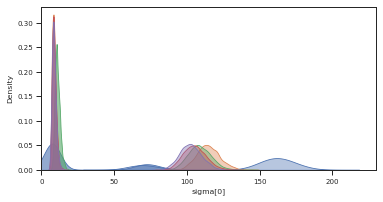

In [50]:
fig, ax = plt.subplots(figsize=(6,3))

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}', alpha=0.4)
        sns.kdeplot(post['sigma[1]'], ax=ax, fill=True, color=f'C{i}', alpha=0.6)
        # sns.kdeplot(post['sigma[2]'], ax=ax, fill=True, color=f'C{i}', alpha=0.8)
    except KeyError as e:
        print(e)

ax.set_xlim(0)
plt.show()

# Exact LOO comparisons

In [ ]:
{
    r'$H_0$': idata_0,
    r'$H_1$': idata_2,
    r'$H_2$': idata_3,
    r'$H_3$': idata_1,
    r'$H_4$': idata_5
}

In [28]:
az.loo(idata_0, pointwise=True)

/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 16 log-likelihood matrix

         Estimate       SE
elpd_loo  -139.96    21.56
p_loo       34.49        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        9   56.2%
 (0.5, 0.7]   (ok)          3   18.8%
   (0.7, 1]   (bad)         1    6.2%
   (1, Inf)   (very bad)    3   18.8%

In [29]:
idata_0

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
class PyMC3Wrapper(az.SamplingWrapper):        
    def sample(self, modified_observed_data):
        with self.model(*modified_observed_data) as linreg_model:
            idata = pm.sample(
                **self.sample_kwargs, 
                return_inferencedata=True, 
                idata_kwargs=self.idata_kwargs
            )
        return idata
    
    def get_inference_data(self, idata):
        return idata
        
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"]
        ydata = self.idata_orig.observed_data["y"]
        mask = np.isin(np.arange(len(xdata)), idx)
        data__i = [ary[~mask] for ary in (xdata, ydata)]
        data_ex = [ary[mask] for ary in (xdata, ydata)]
        return data__i, data_ex

In [30]:
az.reloo(az.SamplingWrapper(model_0, idata_0))

TypeError: Passed wrapper instance does not implement all methods required for reloo to work. Check the documentation of SamplingWrapper. ['sel_observations', 'sample', 'get_inference_data', 'log_likelihood__i'] must be implemented and were not found.

## Old notebook cells

In [10]:
def reactor_test(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD + NADH/k.KI_NADH))

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = integrate.solve_ivp(reactor, y0=[controls.G6P_in, controls.NAD_in, controls.NADH_in], t_span=(0, 60), args=(parameters, controls), vectorized=False).y
    return sol

reactor_test(control_inputs.loc[0], posterior_2.loc[0])[2]

NameError: name 'control_inputs' is not defined

In [118]:
import scipy.integrate as integrate
from numba import njit

control_inputs = pd.DataFrame(
    {
        "kf": 0.125, "E": 2.0,
        # "G6P_in": [2000, 3000, 4000, 5000, 2000, 3000, 4000, 5000],
        # "NAD_in": [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000],
        "G6P_in": [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000],
        "NAD_in": [3000, 3000, 3000, 3000, 2000, 3000, 4000, 5000],
        "NADH_in": [2000, 3000, 4000, 5000, 3000, 3000, 3000, 3000]
    }
)


def reactor_2(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD + NADH/k.KI_NADH))

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = [[integrate.solve_ivp(reactor, y0=[control.G6P_in, control.NAD_in, control.NADH_in], t_span=(0, 60), args=(param, control), vectorized=False).y[2,-1] for i, control in controls.iterrows() ] for j, param in parameters.iterrows()]
    return sol

def reactor_5(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD)*(1+ NADH/k.KI_NADH)**2)

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = [[integrate.solve_ivp(reactor, y0=[control.G6P_in, control.NAD_in, control.NADH_in], t_span=(0, 60), args=(param, control), vectorized=False).y[2,-1] for i, control in controls.iterrows() ]for j, param in parameters.iterrows()]
    return sol

pred_2 = reactor_2(control_inputs, posterior_2.sample(200))

pred_5 = reactor_5(control_inputs, posterior_5.sample(200))

'KI_NADH'


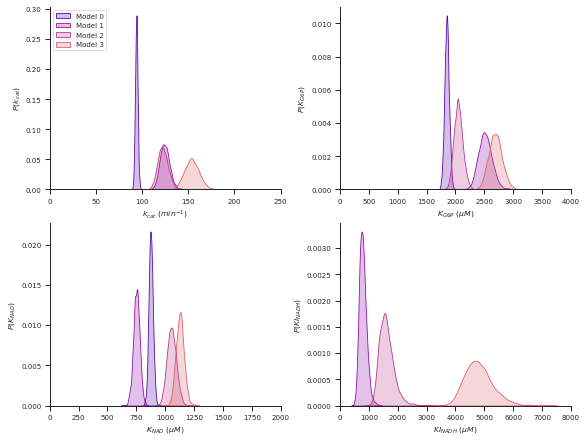

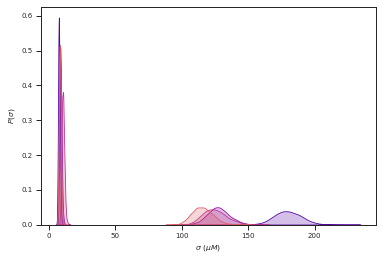

In [ ]:


with sns.color_palette('plasma', n_colors=6):

    fig, axes = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['k_cat'], ax=axes[0][0], fill=True, color=f'C{i}', label=f"Model {i}")

    axes[0][0].set_xlabel(r"$k_{cat}~(min^{-1})$")
    axes[0][0].set_ylabel(r"$P(k_{cat})$")
    axes[0][0].set_xlim(0, 250)
    axes[0][0].legend(loc='upper left')

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['K_G6P'], ax=axes[0][1], fill=True, color=f'C{i}')
    axes[0][1].set_xlabel(r"$K_{G6P}~(\mu M)$")
    axes[0][1].set_ylabel(r"$P(K_{G6P})$")
    axes[0][1].set_xlim(0, 4000)

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['K_NAD'], ax=axes[1][0], fill=True, color=f'C{i}')
    axes[1][0].set_xlabel(r"$K_{NAD}~(\mu M)$")
    axes[1][0].set_ylabel(r"$P(K_{NAD})$")
    axes[1][0].set_xlim(0, 2000)

    for i, post in enumerate(posteriors):
        try:
            sns.kdeplot(post['KI_NADH'], ax=axes[1][1], fill=True, color=f'C{i}')
        except KeyError as e:
            print(e)
    axes[1][1].set_xlabel(r"$KI_{NADH}~(\mu M)$")
    axes[1][1].set_ylabel(r"$P(KI_{NADH})$")
    axes[1][1].set_xlim(0, 8000)

    sns.despine()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    for i, post in enumerate(posteriors):
        sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}')
        sns.kdeplot(post['sigma[1]'], ax=ax, fill=True, color=f'C{i}')
        # sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}')

    ax.set_xlabel(r"$\sigma~(\mu M)$")
    ax.set_ylabel(r"$P(\sigma)$")
# ax.set_xlim(0, 2000)

/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         rank         loo      p_loo      d_loo        weight         se  \
model_5     0 -460.086011   9.995511   0.000000  4.308970e-01  20.572814   
model_1     1 -463.559869  10.288714   3.473858  0.000000e+00  21.193274   
model_2     2 -470.557057  11.579056  10.471046  0.000000e+00  21.580386   
model_4     3 -474.838169  11.453683  14.752158  2.548756e-13  20.754832   
model_3     4 -482.743593  12.970784  22.657582  4.585695e-13  22.142735   
model_0     5 -486.556216  12.652510  26.470204  5.691030e-01  35.711813   

               dse  warning loo_scale  
model_5   0.000000    False       log  
model_1   1.915862    False       log  
model_2   5.030913    False       log  
model_4   3.128812    False       log  
model_3   6.605258    False       log  
model_0  23.389344     True       log  


<AxesSubplot:xlabel='Log'>

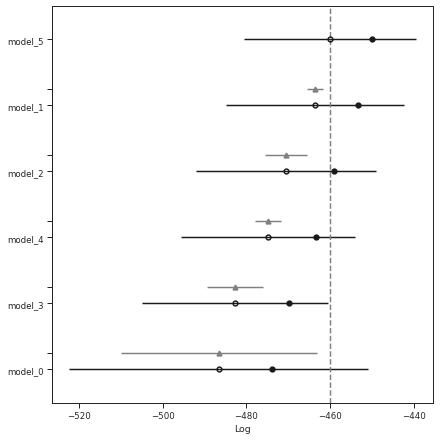

In [ ]:
model_comparison = az.compare({
    'model_0': idata_0,
    'model_1': idata_1,
    'model_2': idata_2,
    'model_3': idata_3,
    'model_4': idata_4,
    'model_5': idata_5,
}, ic='loo')
print(model_comparison)
az.plot_compare(model_comparison)

In [119]:
pred_2_arr = np.array(pred_2) - control_inputs.NADH_in.values
pred_5_arr = np.array(pred_5) - control_inputs.NADH_in.values

(0.0, 587.1013063884353)

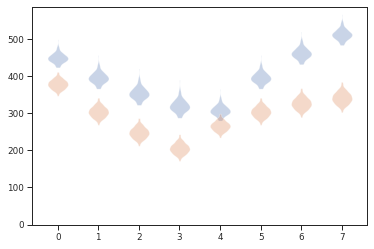

In [120]:
plt.violinplot(pred_2_arr, positions=np.arange(0, len(control_inputs)), showextrema=False)
plt.violinplot(pred_5_arr, positions=np.arange(0, len(control_inputs)), showextrema=False)
plt.ylim(0)